# Exercise 2 - ANN classification

Dataset: https://www.kaggle.com/datasets/priyamchoksi/adult-census-income-dataset?resource=download

For this exercise I have selected a dataset about the income of US citizens. The target variable is income which is split into two groups, >50k and <50k. 

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [389]:
df = pd.read_csv("adult.csv", na_values="?") # I asked ChatGPT how I can set the "?" as null values so I can work with df.isnull().sum()
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [390]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [391]:
df.shape[0]

32561

In [392]:
df.duplicated().sum()

np.int64(24)

I have 32 561 rows of data in this dataset, 24 duplicate entries and missing values only in the variables "workclass", "occupation" and "native.country". Since I have more than 30 000 rows of data I think I can just remove the null values and duplicates and still have enough data left over.

In [393]:
df = df.drop_duplicates()

In [394]:
df.duplicated().sum()

np.int64(0)

In [395]:
df = df.dropna()

In [396]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [397]:
df["income"].value_counts()

income
<=50K    22633
>50K      7506
Name: count, dtype: int64

### Checking and correcting each Variable

#### Age

In [398]:
df["age"].value_counts()

age
36    852
31    851
33    837
34    836
37    828
     ... 
82      7
83      5
88      3
85      3
86      1
Name: count, Length: 72, dtype: int64

Age is already a metric variable and has no missing values

#### workclass

In [399]:
df["workclass"].value_counts()

workclass
Private             22264
Self-emp-not-inc     2498
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64

In [400]:
# I asked ChatGPT to combine the variables with less than 1000 mentions into one column called "other"
rare_classes = df['workclass'].value_counts()[df['workclass'].value_counts() < 1000].index
df['workclass'] = df['workclass'].replace(rare_classes, 'Other') 
df = pd.get_dummies(df, columns=['workclass'])

In [401]:
df.head()

,age,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_Local-gov,workclass_Other,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov
1,82,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,False,False,True,False,False,False
3,54,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,False,False,True,False,False,False
4,41,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,False,False,True,False,False,False
5,34,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K,False,False,True,False,False,False
6,38,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K,False,False,True,False,False,False


#### fnlwgt

In [402]:
df["fnlwgt"].value_counts()

fnlwgt
203488    13
164190    12
123011    12
121124    12
148995    12
          ..
113987     1
177669     1
63079      1
381895     1
436163     1
Name: count, Length: 20263, dtype: int64

#### education

In [403]:
df["education"].value_counts()

education
HS-grad         9834
Some-college    6669
Bachelors       5042
Masters         1626
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          556
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          287
1st-4th          149
Preschool         44
Name: count, dtype: int64

In [404]:
# I asked ChatGPT to combine 1st through 4th into elementary school, 5th through 8th into middle school and 9th through 12th into high school
education_map = {
    '1st-4th': 'Elementary-school',
    '5th-6th': 'Middle-school',
    '7th-8th': 'Middle-school',
    '9th': 'High-school',
    '10th': 'High-school',
    '11th': 'High-school',
    '12th': 'High-school'
}

df['education'] = df['education'].replace(education_map)

In [405]:
df['education'].value_counts()

education
HS-grad              9834
Some-college         6669
Bachelors            5042
High-school          2700
Masters              1626
Assoc-voc            1307
Assoc-acdm           1008
Middle-school         843
Prof-school           542
Doctorate             375
Elementary-school     149
Preschool              44
Name: count, dtype: int64

I am going to combine values with less than 1000 mentions into a column called other again, same as I did before

In [406]:
rare_education = df['education'].value_counts()[df['education'].value_counts() < 1000].index
df['education'] = df['education'].replace(rare_education, 'Other') 
df = pd.get_dummies(df, columns=['education'])

In [407]:
df.head()

,age,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,...,workclass_Self-emp-not-inc,workclass_State-gov,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_HS-grad,education_High-school,education_Masters,education_Other,education_Some-college
1,82,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,...,False,False,False,False,False,True,False,False,False,False
3,54,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,...,False,False,False,False,False,False,False,False,True,False
4,41,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,...,False,False,False,False,False,False,False,False,False,True
5,34,216864,9,Divorced,Other-service,Unmarried,White,Female,0,3770,...,False,False,False,False,False,True,False,False,False,False
6,38,150601,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,...,False,False,False,False,False,False,True,False,False,False


#### marital status

In [408]:
df["marital.status"].value_counts()

marital.status
Married-civ-spouse       14059
Never-married             9711
Divorced                  4212
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: count, dtype: int64

I am going to combine "Married-civ-absent" and "Married-AF-spouse" into one column, since the second is too small to warrant its own column I believe

In [409]:
df['marital.status'] = df['marital.status'].replace('Married-AF-spouse', 'Married-civ-spouse') # I asked ChatGPT to combine these two

In [410]:
df = pd.get_dummies(df, columns=['marital.status'])

In [411]:
df.head()

,age,fnlwgt,education.num,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,...,education_High-school,education_Masters,education_Other,education_Some-college,marital.status_Divorced,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed
1,82,132870,9,Exec-managerial,Not-in-family,White,Female,0,4356,18,...,False,False,False,False,False,False,False,False,False,True
3,54,140359,4,Machine-op-inspct,Unmarried,White,Female,0,3900,40,...,False,False,True,False,True,False,False,False,False,False
4,41,264663,10,Prof-specialty,Own-child,White,Female,0,3900,40,...,False,False,False,True,False,False,False,False,True,False
5,34,216864,9,Other-service,Unmarried,White,Female,0,3770,45,...,False,False,False,False,True,False,False,False,False,False
6,38,150601,6,Adm-clerical,Unmarried,White,Male,0,3770,40,...,True,False,False,False,False,False,False,False,True,False


#### occupation

In [412]:
df["occupation"].value_counts()

occupation
Prof-specialty       4034
Craft-repair         4025
Exec-managerial      3991
Adm-clerical         3719
Sales                3584
Other-service        3209
Machine-op-inspct    1964
Transport-moving     1572
Handlers-cleaners    1349
Farming-fishing       987
Tech-support          911
Protective-serv       644
Priv-house-serv       141
Armed-Forces            9
Name: count, dtype: int64

Once again, I will combine the values with less than 1000 entries

In [413]:
rare_occupation = df['occupation'].value_counts()[df['occupation'].value_counts() < 1000].index
df['occupation'] = df['occupation'].replace(rare_occupation, 'Other') 
df = pd.get_dummies(df, columns=['occupation'])

In [414]:
df.head()

,age,fnlwgt,education.num,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,...,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving
1,82,132870,9,Not-in-family,White,Female,0,4356,18,United-States,...,False,False,True,False,False,False,False,False,False,False
3,54,140359,4,Unmarried,White,Female,0,3900,40,United-States,...,False,False,False,False,True,False,False,False,False,False
4,41,264663,10,Own-child,White,Female,0,3900,40,United-States,...,False,False,False,False,False,False,False,True,False,False
5,34,216864,9,Unmarried,White,Female,0,3770,45,United-States,...,False,False,False,False,False,False,True,False,False,False
6,38,150601,6,Unmarried,White,Male,0,3770,40,United-States,...,True,False,False,False,False,False,False,False,False,False


#### relationship

In [415]:
df["relationship"].value_counts()

relationship
Husband           12457
Not-in-family      7714
Own-child          4462
Unmarried          3211
Wife               1406
Other-relative      889
Name: count, dtype: int64

I am going to leave the groupings as is since there is already the variable other-relative

In [416]:
df = pd.get_dummies(df, columns=['relationship'])

In [417]:
df.head()

,age,fnlwgt,education.num,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,...,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
1,82,132870,9,White,Female,0,4356,18,United-States,<=50K,...,False,False,False,False,False,True,False,False,False,False
3,54,140359,4,White,Female,0,3900,40,United-States,<=50K,...,False,False,False,False,False,False,False,False,True,False
4,41,264663,10,White,Female,0,3900,40,United-States,<=50K,...,False,True,False,False,False,False,False,True,False,False
5,34,216864,9,White,Female,0,3770,45,United-States,<=50K,...,True,False,False,False,False,False,False,False,True,False
6,38,150601,6,White,Male,0,3770,40,United-States,<=50K,...,False,False,False,False,False,False,False,False,True,False


#### race

In [418]:
df["race"].value_counts()

race
White                 25912
Black                  2816
Asian-Pac-Islander      894
Amer-Indian-Eskimo      286
Other                   231
Name: count, dtype: int64

same as before with the relationship

In [419]:
df = pd.get_dummies(df, columns=['race'])

In [420]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
1,82,132870,9,Female,0,4356,18,United-States,<=50K,False,...,True,False,False,False,False,False,False,False,False,True
3,54,140359,4,Female,0,3900,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
4,41,264663,10,Female,0,3900,40,United-States,<=50K,False,...,False,False,True,False,False,False,False,False,False,True
5,34,216864,9,Female,0,3770,45,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
6,38,150601,6,Male,0,3770,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True


#### sex

In [421]:
df["sex"].value_counts()

sex
Male      20366
Female     9773
Name: count, dtype: int64

In [422]:
df['sex'] = (df['sex'] == 'Male').astype(int) # I asked ChatGPT to convert it to numerical values

In [423]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
1,82,132870,9,0,0,4356,18,United-States,<=50K,False,...,True,False,False,False,False,False,False,False,False,True
3,54,140359,4,0,0,3900,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
4,41,264663,10,0,0,3900,40,United-States,<=50K,False,...,False,False,True,False,False,False,False,False,False,True
5,34,216864,9,0,0,3770,45,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
6,38,150601,6,1,0,3770,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True


#### capital.gain, capital.loss, hours.per.week
since they are already numerical values, I decided not to do anything different with them.

#### native.country

In [424]:
df["native.country"].value_counts()

native.country
United-States                 27487
Mexico                          606
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
Italy                            68
China                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        61
Japan                            59
Poland                           56
Columbia                         56
Taiwan                           42
Haiti                            42
Iran                             42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
Ecuador      

In [425]:
# I asked ChatGPT to map every country to its continent 
# I don't know what South is supposed to refer to, so I put it to other
# I put central and South America together, because they didn't have that many values 

continent_map = {
    # North America
    'United-States': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',
    'Puerto-Rico': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'North America',
    
    # Central/South America
    'El-Salvador': 'South America',
    'Cuba': 'South America',
    'Jamaica': 'South America',
    'Dominican-Republic': 'South America',
    'Guatemala': 'South America',
    'Columbia': 'South America',
    'Nicaragua': 'South America',
    'Peru': 'South America',
    'Ecuador': 'South America',
    'Trinadad&Tobago': 'South America',
    'Honduras': 'South America',
    'Haiti': 'South America',

    # Europe
    'Germany': 'Europe',
    'England': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Greece': 'Europe',
    'France': 'Europe',
    'Ireland': 'Europe',
    'Hungary': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Holand-Netherlands': 'Europe',

    # Asia
    'Philippines': 'Asia',
    'India': 'Asia',
    'China': 'Asia',
    'Vietnam': 'Asia',
    'Japan': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Asia',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Laos': 'Asia',
    'Hong': 'Asia',

    # Other/Unknown
    'South': 'Other'
}

df['native.country'] = df['native.country'].replace(continent_map)

In [426]:
df["native.country"].value_counts()

native.country
North America    28323
Asia               634
South America      618
Europe             493
Other               71
Name: count, dtype: int64

In [427]:
df = pd.get_dummies(df, columns=['native.country'])

In [428]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,income,workclass_Local-gov,workclass_Other,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native.country_Asia,native.country_Europe,native.country_North America,native.country_Other,native.country_South America
1,82,132870,9,0,0,4356,18,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
3,54,140359,4,0,0,3900,40,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
4,41,264663,10,0,0,3900,40,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
5,34,216864,9,0,0,3770,45,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
6,38,150601,6,1,0,3770,40,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False


In [429]:
df['income'] = (df['income'] == '>50K').astype(int)

In [430]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,income,workclass_Local-gov,workclass_Other,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native.country_Asia,native.country_Europe,native.country_North America,native.country_Other,native.country_South America
1,82,132870,9,0,0,4356,18,0,False,False,...,False,False,False,False,True,False,False,True,False,False
3,54,140359,4,0,0,3900,40,0,False,False,...,False,False,False,False,True,False,False,True,False,False
4,41,264663,10,0,0,3900,40,0,False,False,...,False,False,False,False,True,False,False,True,False,False
5,34,216864,9,0,0,3770,45,0,False,False,...,False,False,False,False,True,False,False,True,False,False
6,38,150601,6,1,0,3770,40,0,False,False,...,False,False,False,False,True,False,False,True,False,False


In [431]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   30139 non-null  int64
 1   fnlwgt                                30139 non-null  int64
 2   education.num                         30139 non-null  int64
 3   sex                                   30139 non-null  int64
 4   capital.gain                          30139 non-null  int64
 5   capital.loss                          30139 non-null  int64
 6   hours.per.week                        30139 non-null  int64
 7   income                                30139 non-null  int64
 8   workclass_Local-gov                   30139 non-null  bool 
 9   workclass_Other                       30139 non-null  bool 
 10  workclass_Private                     30139 non-null  bool 
 11  workclass_Self-emp-inc                30139 no

I had an issue with the datatype not matching up when I wanted to calculate the roc-auc score so I asked ChatGPT what an issue could be and it advised me to change the datatype to float32 which then rectified the errors I had.

In [432]:
df = df.astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   30139 non-null  float32
 1   fnlwgt                                30139 non-null  float32
 2   education.num                         30139 non-null  float32
 3   sex                                   30139 non-null  float32
 4   capital.gain                          30139 non-null  float32
 5   capital.loss                          30139 non-null  float32
 6   hours.per.week                        30139 non-null  float32
 7   income                                30139 non-null  float32
 8   workclass_Local-gov                   30139 non-null  float32
 9   workclass_Other                       30139 non-null  float32
 10  workclass_Private                     30139 non-null  float32
 11  workclass_Self-emp-i

## Correlation Matrix and Chi-Square Feature Importance

In [433]:
corr_matrix = df.corr()['income']
corr_matrix.sort_values(ascending=False)

income                                  1.00
marital.status_Married-civ-spouse       0.45
relationship_Husband                    0.40
education.num                           0.34
age                                     0.24
hours.per.week                          0.23
capital.gain                            0.22
sex                                     0.22
occupation_Exec-managerial              0.21
occupation_Prof-specialty               0.18
education_Bachelors                     0.18
education_Masters                       0.17
capital.loss                            0.15
workclass_Self-emp-inc                  0.14
relationship_Wife                       0.13
race_White                              0.08
education_Other                         0.08
workclass_Other                         0.06
workclass_Local-gov                     0.03
workclass_Self-emp-not-inc              0.03
native.country_Asia                     0.02
occupation_Sales                        0.02
native.cou

In [434]:
X = df.drop('income', axis=1)

y_temp = df['income']

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)

categories = list(le.classes_)
categories = list(map(str, categories))
categories

['0.0', '1.0']

In [435]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
4,capital.gain,74075359.33
5,capital.loss,1254636.44
1,fnlwgt,143332.31
0,age,7918.19
6,hours.per.week,5561.15
22,marital.status_Married-civ-spouse,3194.70
37,relationship_Husband,2845.27
2,education.num,2175.89
24,marital.status_Never-married,2090.44
40,relationship_Own-child,1314.23


In [436]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [437]:
# I asked ChatGPT to implement Dropout layers, EarlyStop and ReduceLROnPlateau
# Define the model
model = keras.Sequential([
    keras.Input(shape=(len(X.columns),)), 
    layers.BatchNormalization(),
    layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
    layers.Dropout(0.3),   
    layers.Dense(8, activation="relu"),
    layers.Dropout(0.2),   
    layers.Dense(len(categories), activation="softmax")  
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Summarize the model
model.summary()

Epoch 1/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7217 - loss: 2.5476 - val_accuracy: 0.7454 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 2/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7663 - loss: 0.5217 - val_accuracy: 0.7715 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 3/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7940 - loss: 0.5044 - val_accuracy: 0.8076 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 4/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7951 - loss: 0.4966 - val_accuracy: 0.8284 - val_loss: 0.4618 - learning_rate: 0.0010
Epoch 5/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7995 - loss: 0.4912 - val_accuracy: 0.8275 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 6/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8031 - loss: 0.4926 - val_accuracy: 0.8339 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 7/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8061 - loss: 0.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 53)             │           212 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,480 (13.60 KB)

 Trainable params: 1,124 (4.39 KB)

 Non-trainable params: 106 (424.00 B)

 Optimizer params: 2,250 (8.79 KB)

## Error and performance metrics

<Axes: >

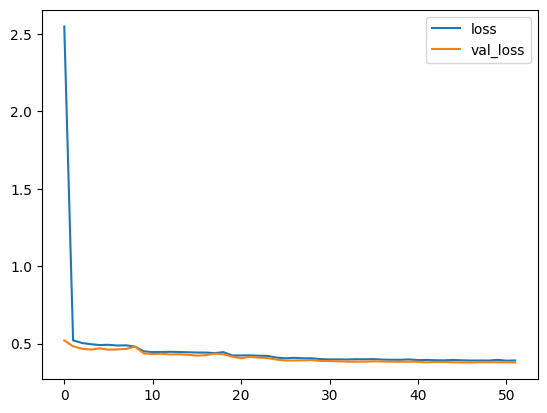

In [438]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

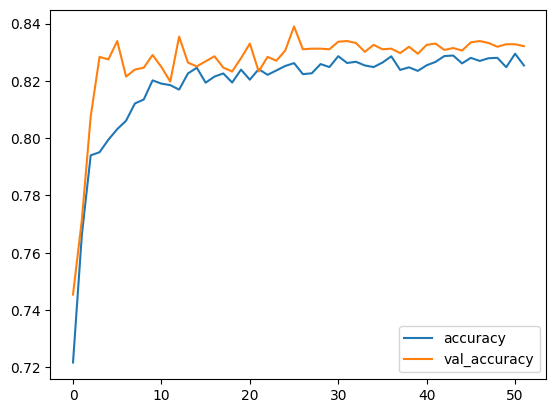

In [439]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [440]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.3557717204093933, 0.8425127267837524]

Train data evaluation:
[0.3614377975463867, 0.8432004451751709]


In [441]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

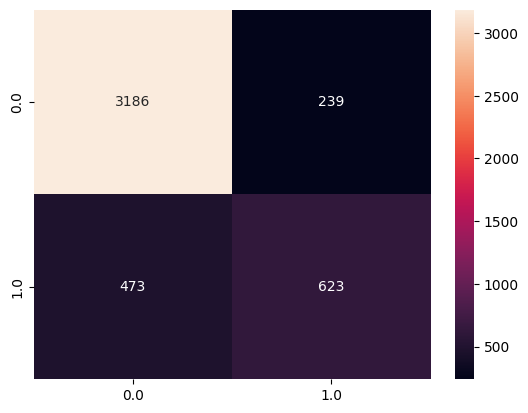

In [442]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

The model correctly classified 3186 individuals as earning less than 50K and 623 as earning more than 50K. However, it misclassified 473 people with high-income as low-income and 239 people with low-income as high-income. Overall, the matrix shows that the model performs very well in identifying lower-income individuals, while some high-income cases are missed.

In [443]:
print(classification_report(y_test, test_predictions, target_names=["<=50K", ">50K"]))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      3425
        >50K       0.72      0.57      0.64      1096

    accuracy                           0.84      4521
   macro avg       0.80      0.75      0.77      4521
weighted avg       0.83      0.84      0.84      4521


Model overall accuracy: 84.25%


The model achieved an overall accuracy of 84.25% which is combined with the roc-auc score down below a good result. In general, the model performs better at predicting individuals with an income of less than 50K (precision = 0.87, recall = 0.93, F1 = 0.90) compared to those earning more than 50K (precision = 0.72, recall = 0.57, F1 = 0.64). This might be because of the different number of samples per class. 

In [444]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

942/942 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.9000122072035592

My roc_auc_score is just above 0.9 which is quite the good result

I asked ChatGPT to give me two samples with some random values to test my model with

In [445]:
example_high = {
    "age": 45,
    "fnlwgt": 200000,
    "education.num": 16,     # Masters/PhD
    "sex": 1,                # Male
    "capital.gain": 5000,
    "capital.loss": 0,
    "hours.per.week": 50,
    "marital.status_Married-civ-spouse": 1,
    "relationship_Husband": 1,
    "education_Masters": 1,
    "occupation_Exec-managerial": 1,
    "workclass_Self-emp-inc": 1,
    "race_White": 1,
    # all other boolean features should be 0
}

example_low = {
    "age": 22,
    "fnlwgt": 150000,
    "education.num": 9,      # Some-college or HS
    "sex": 0,                # Female
    "capital.gain": 0,
    "capital.loss": 0,
    "hours.per.week": 25,
    "marital.status_Never-married": 1,
    "relationship_Not-in-family": 1,
    "education_HS-grad": 1,
    "occupation_Other-service": 1,
    "workclass_Private": 1,
    "race_Black": 1,
}

# Make sure all columns exist (missing ones filled with 0)
def make_full_row(example_dict, X):
    row = pd.DataFrame([example_dict])
    for col in X.columns:
        if col not in row.columns:
            row[col] = 0
    return row[X.columns]  # same column order as training

# Prepare examples
row_high = make_full_row(example_high, X)
row_low = make_full_row(example_low, X)

# Predict
pred_high = model.predict(row_high)
pred_low = model.predict(row_low)

print("High income prediction:", pred_high)
print("Low income prediction:", pred_low)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
High income prediction: [[0.23959365 0.7604063 ]]
Low income prediction: [[0.99359965 0.00640033]]


So I received from ChatGPT two samples, one of which should probably turn out to be in the high income group and the other in the lower one and the probability of the first example to have an income of more than 50k is 0.76 and the probability of the second one to have an income of less than 50k is 0.99